# Знакомство с данными

## Импорт библиотек, необходимых для работ

In [20]:
import numpy as np # линейная алгебра
import pandas as pd # для анализа и предобработки данных
import matplotlib
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации
import plotly.express as px # для визуализации
from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
import statistics
from collections import Counter
from functools import reduce
import category_encoders as ce
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка

%matplotlib inline
plt.style.use('seaborn-v0_8')

from scipy.stats import shapiro
from scipy.stats import normaltest
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from sklearn import model_selection


from functools import reduce

## Загрузка данных

In [21]:
nafld = pd.read_csv('D:\курс по data science\IDE\diplom_project\data_2\\nafld_after_eda.csv')
display(nafld.head())

,id,age,male,bmi,status,nafld,dyslipidemia,ang/isc,diabetes,stroke,...,bmi_category_pre-obesity,bmi_category_healthy,bmi_category_obese (class III),bmi_category_underweight,bmi_category_severe underweight,result_chol_mediana_normal,result_chol_mediana_ideal,result_chol_mediana_low,result_chol_mediana_nan,result_hdl_mediana_nan
0,3,53.0,1.0,30.5,0.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4,56.0,1.0,37.8,0.0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,5,68.0,1.0,29.4,1.0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,7,49.0,0.0,25.5,0.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,9,47.0,1.0,31.4,0.0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Матрица корреляций и наиболее коррелированные с целевым признаокм факторы:

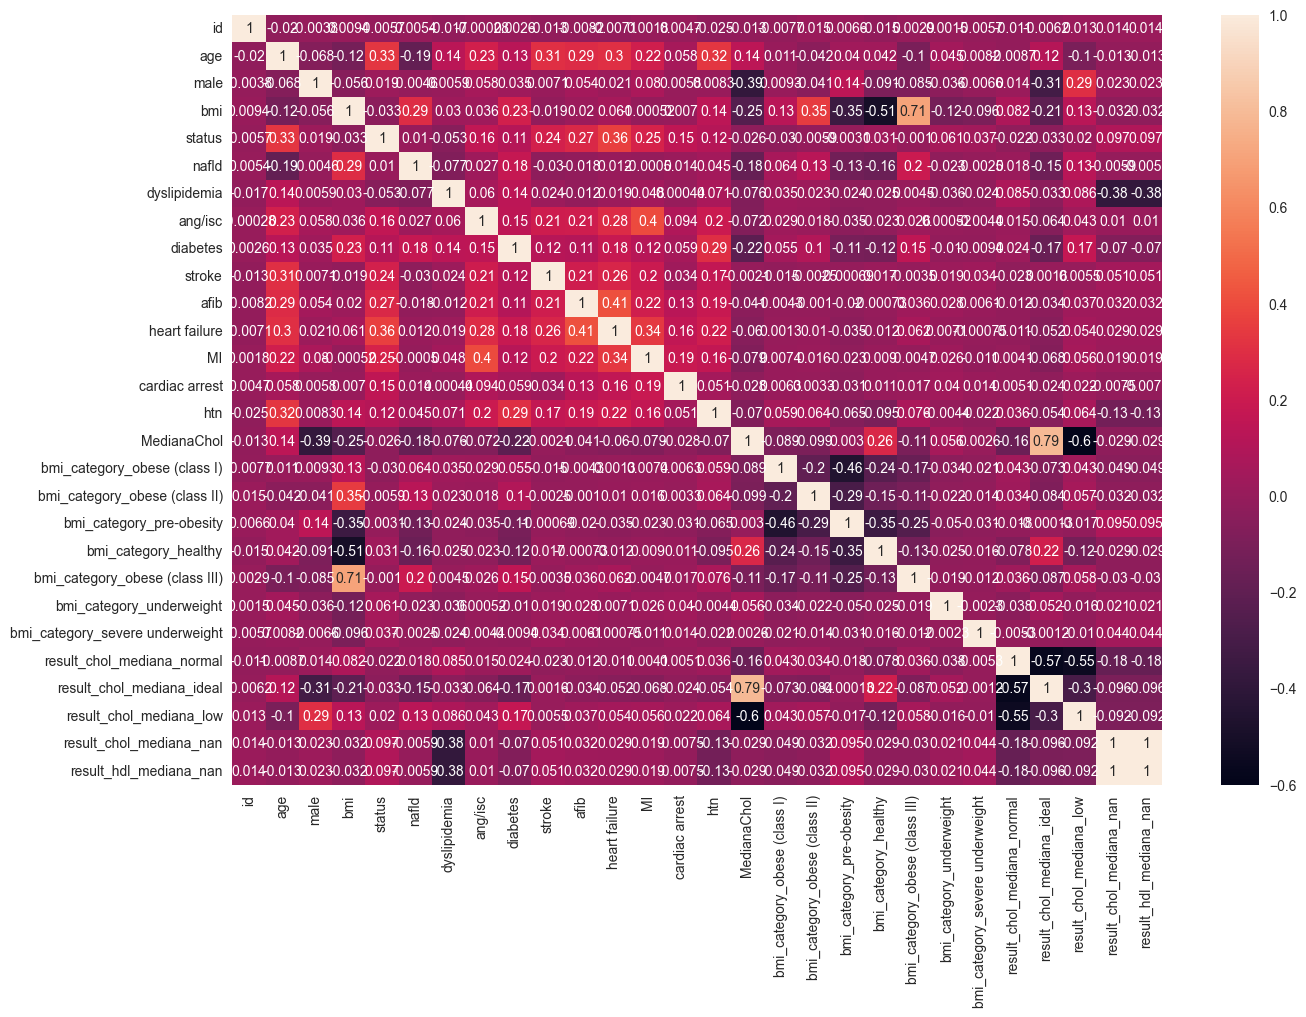

In [22]:
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(nafld.corr(), annot=True);

Из строки nafld видно, что наибольшей корреляцией с целевым признаком обладают факторы diabetes (наличие диабета) и BMI (индекс массы тела).

Построим диаграмму рассеяния, по оси абсцисс отложим фактор diabetes, а по оси ординат — BMI. Сделаем цветовую группировку по признаку наличия nafld:

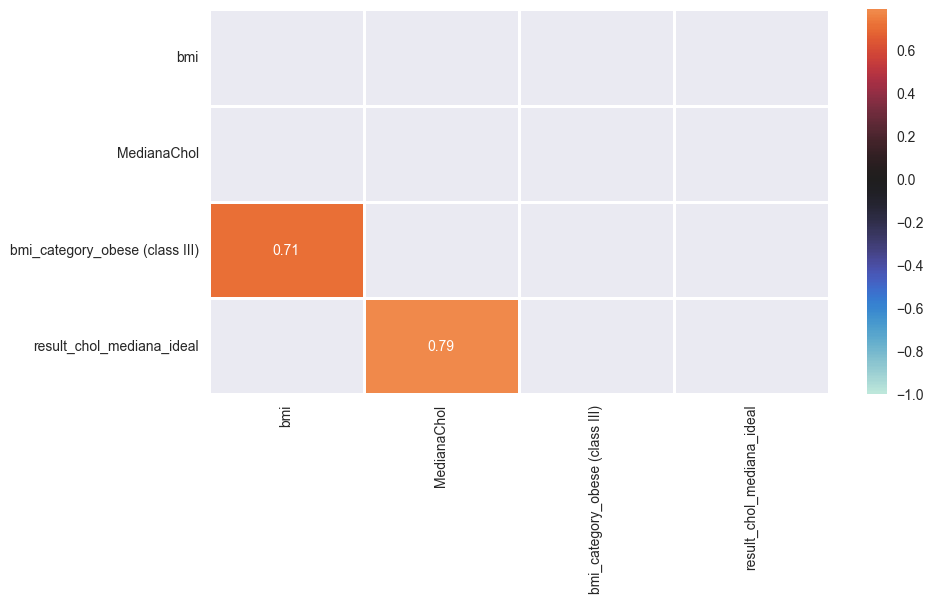

In [23]:
# Построим корреляцию и отфильтруем по очень сильной взаимосвязи
df_corr = nafld.corr()
df_corr = df_corr[(df_corr < 1) & (abs(df_corr) > 0.7)]
df_corr = df_corr.dropna(thresh=1, axis=0)
df_corr = df_corr.dropna(thresh=1, axis=1)
matrix = np.triu(df_corr)

# Визуализируем матрицу корреляции
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(df_corr, annot=True, ax=ax, mask=matrix, linewidths=1, center=0, vmin=-1);

In [24]:
# Удалим мультиколлинеальные признаки
data = nafld.drop(['bmi_category_obese (class III)', 'result_chol_mediana_ideal'], axis=1)

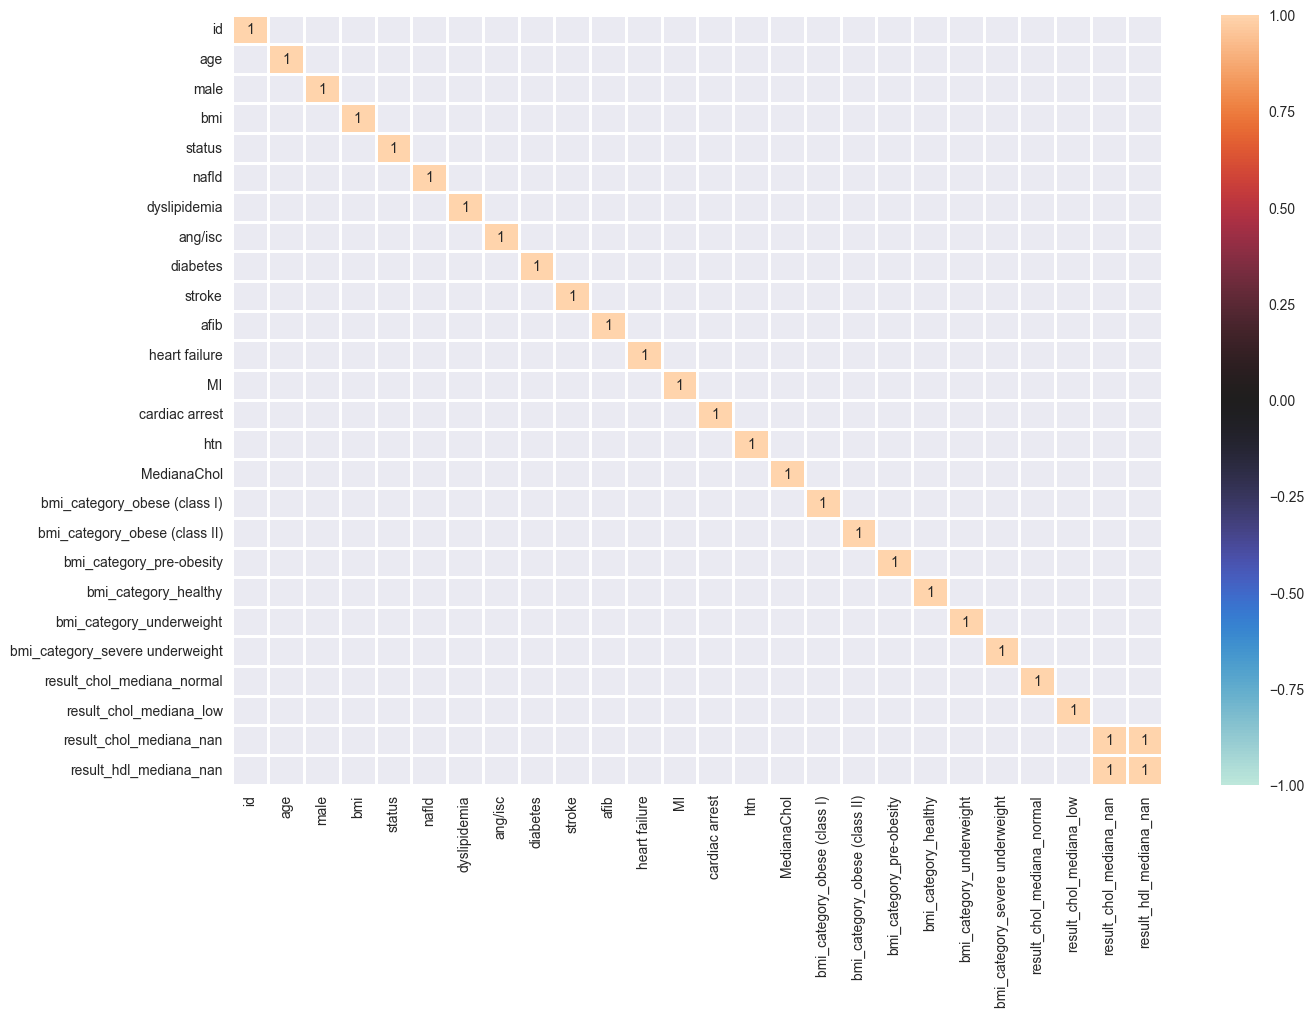

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
mask = np.array(abs(data.corr()) < 0.7)
sns.heatmap(data.corr(), annot=True, ax=ax, center=0, vmin=-1, linewidths=1, mask=mask);

## Отбор признаков

In [28]:
train_data = data.copy()
train_data.head(3)

,id,age,male,bmi,status,nafld,dyslipidemia,ang/isc,diabetes,stroke,...,bmi_category_obese (class I),bmi_category_obese (class II),bmi_category_pre-obesity,bmi_category_healthy,bmi_category_underweight,bmi_category_severe underweight,result_chol_mediana_normal,result_chol_mediana_low,result_chol_mediana_nan,result_hdl_mediana_nan
0,3,53.0,1.0,30.5,0.0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,4,56.0,1.0,37.8,0.0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,5,68.0,1.0,29.4,1.0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [29]:
train_data.drop(columns=['id'], inplace=True)
print('Количество столбцов: {}'.format(train_data.shape[1]))

Количество столбцов: 25


сформируем матрицу наблюдений X, вектор целевой переменной y. В матрицу наблюдений войдут все столбцы из таблицы за исключением целевого признака nafld 

In [30]:
X = train_data.drop(['nafld'], axis=1)
y = train_data['nafld']

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:
Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

In [31]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(X, y, stratify=y,
test_size=0.2, random_state=1)


In [32]:
train_data.columns.tolist()

['age',
 'male',
 'bmi',
 'status',
 'nafld',
 'dyslipidemia',
 'ang/isc',
 'diabetes',
 'stroke',
 'afib',
 'heart failure',
 'MI',
 'cardiac arrest',
 'htn',
 'MedianaChol',
 'bmi_category_obese (class I)',
 'bmi_category_obese (class II)',
 'bmi_category_pre-obesity',
 'bmi_category_healthy',
 'bmi_category_underweight',
 'bmi_category_severe underweight',
 'result_chol_mediana_normal',
 'result_chol_mediana_low',
 'result_chol_mediana_nan',
 'result_hdl_mediana_nan']

Изучим важность категориальных признаков

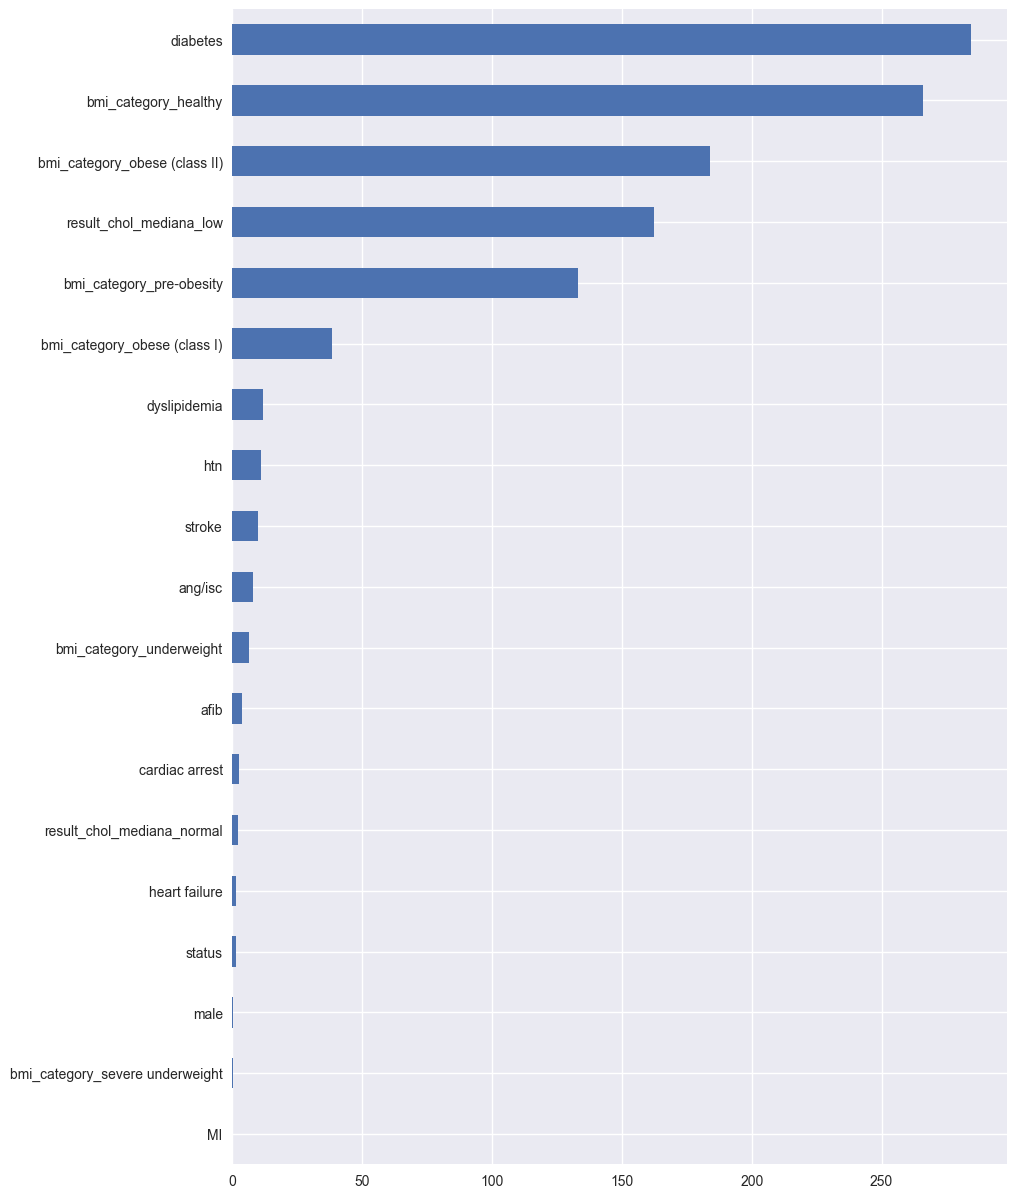

In [33]:
from sklearn.feature_selection import chi2

# категориальные признаки
cat_cols = ['male', 'status', 'dyslipidemia', 'ang/isc', 'diabetes', 'stroke', 'afib', 'heart failure', 
            'MI', 'cardiac arrest', 'htn','bmi_category_obese (class I)',
            'bmi_category_obese (class II)', 'bmi_category_pre-obesity', 
            'bmi_category_healthy', 'bmi_category_underweight', 'bmi_category_severe underweight', 
            'result_chol_mediana_normal', 'result_chol_mediana_low']

y = y.astype('int')
# Проанализируем важность категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', figsize = (10,15));

In [34]:
# Уберем малозначимые признаки
train_data.drop([
    'male', 'status', 'heart failure', 'MI', 'cardiac arrest','bmi_category_severe underweight', 
    'result_chol_mediana_normal'
], axis=1, inplace=True)

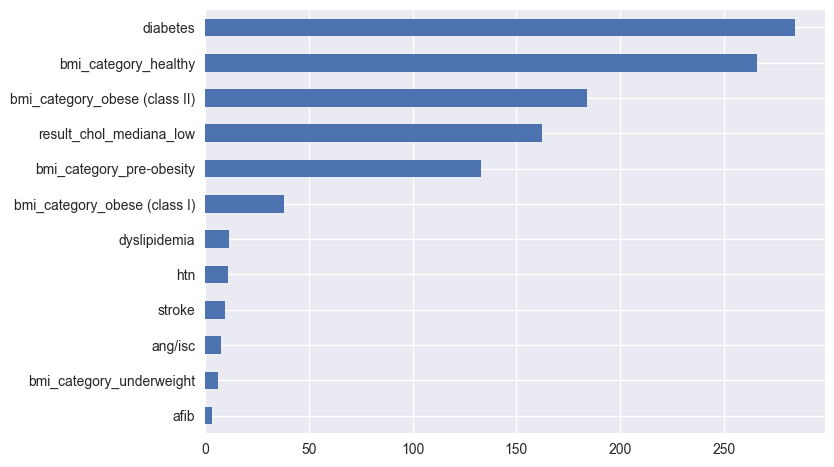

In [35]:
from sklearn.feature_selection import chi2 

# категориальные признаки
cat_cols = [
    'dyslipidemia', 'ang/isc', 'diabetes', 'stroke', 'afib', 'htn','bmi_category_obese (class I)',
    'bmi_category_obese (class II)', 'bmi_category_pre-obesity', 'bmi_category_healthy', 
    'bmi_category_underweight', 'result_chol_mediana_low'
]

y = y.astype('int')
# Проанализируем важность категориальных признаков
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

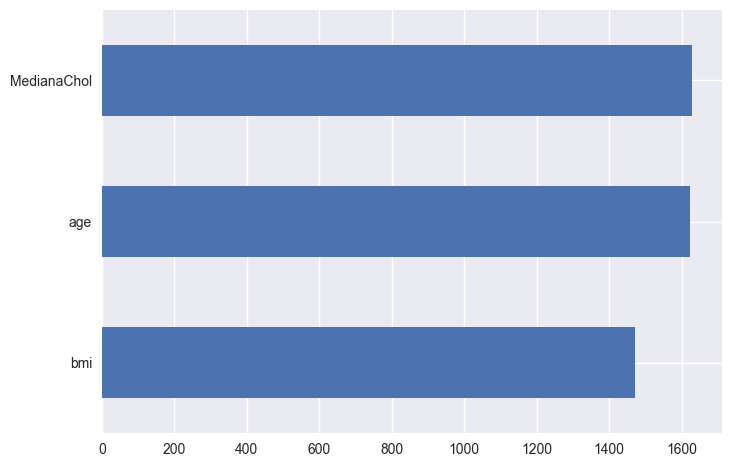

In [69]:
from sklearn.feature_selection import chi2 

# непрерывные признаки
num_cols = [
    'bmi', 'age', 'MedianaChol'
]

y = y.astype('int')
# Проанализируем важность непрерывных признаков
imp_num = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Проверим распределение признаков

In [78]:
# гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# уровень значимости
alpha = 0.05

# Тест Шапиро-Уилка
_, p = shapiro(train_data)
print('p = %.3f' % p)

if p > alpha:
    print(H0)
else:
    print(Ha)

p = 0.000
Данные не распределены нормально (мы отвергаем H0)


c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [79]:
# Тест Д`Агастино для данных столбца
_, p = normaltest(train_data)
print('p = %.3f' % p[6])

if p[0] > alpha/2:
	print(H0)
else:
	print(Ha)

p = 0.000
Данные не распределены нормально (мы отвергаем H0)


Изучим нормальность распределений числовых параметров

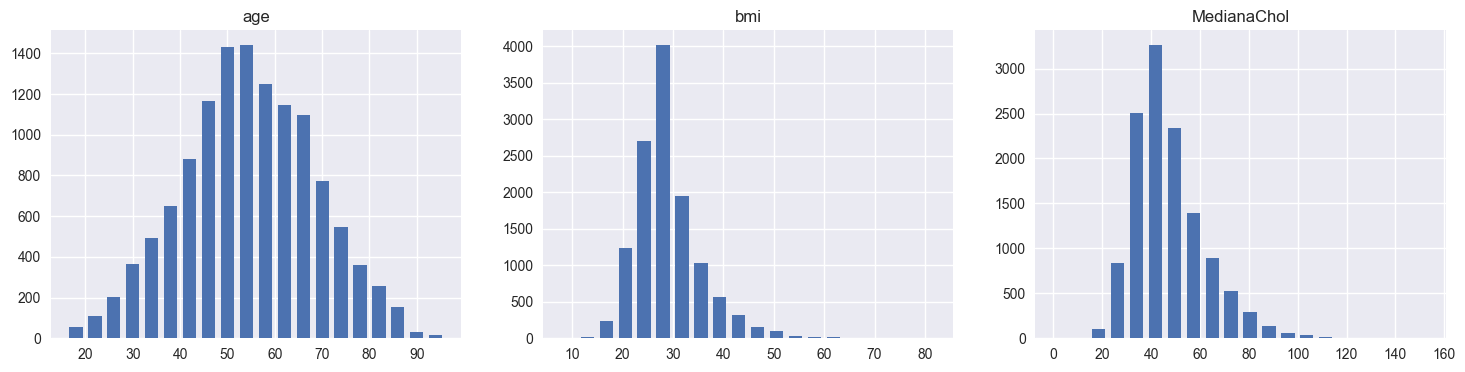

In [81]:
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
  
visnormaldistrib({'age': train_data['age'], 'bmi': train_data['bmi'],'MedianaChol': train_data['MedianaChol'],})

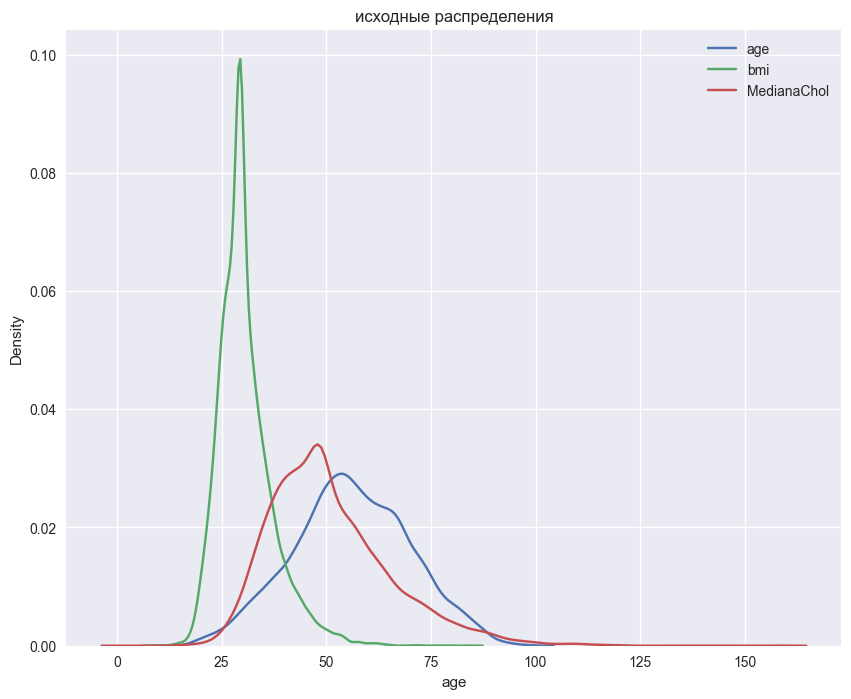

In [83]:
digital_features = ['age', 'bmi', 'MedianaChol']
filtered_df = train_data[digital_features]

col_names = list(filtered_df.columns)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('исходные распределения')


sns.kdeplot(filtered_df['age'], ax=ax1, label='age')
sns.kdeplot(filtered_df['bmi'], ax=ax1, label='bmi')
sns.kdeplot(filtered_df['MedianaChol'], ax=ax1, label='MedianaChol')
plt.legend()

Попробуем нормализовать MinMaxScaler'ром:

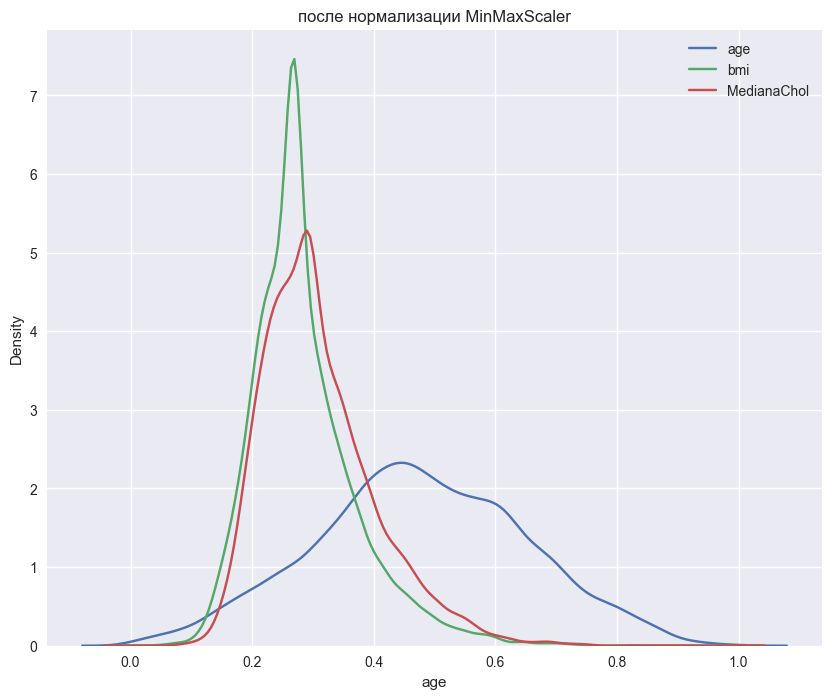

In [84]:
filtered_df = train_data[digital_features]

col_names = list(filtered_df.columns)

mm_scaler = MinMaxScaler()

df_mm = mm_scaler.fit_transform(filtered_df)

df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации MinMaxScaler')


sns.kdeplot(df_mm['age'], ax=ax1, label='age')
sns.kdeplot(df_mm['bmi'], ax=ax1, label='bmi')
sns.kdeplot(df_mm['MedianaChol'], ax=ax1, label='MedianaChol')
plt.legend()

Попробуем нормализовать RobustScaler'ром:

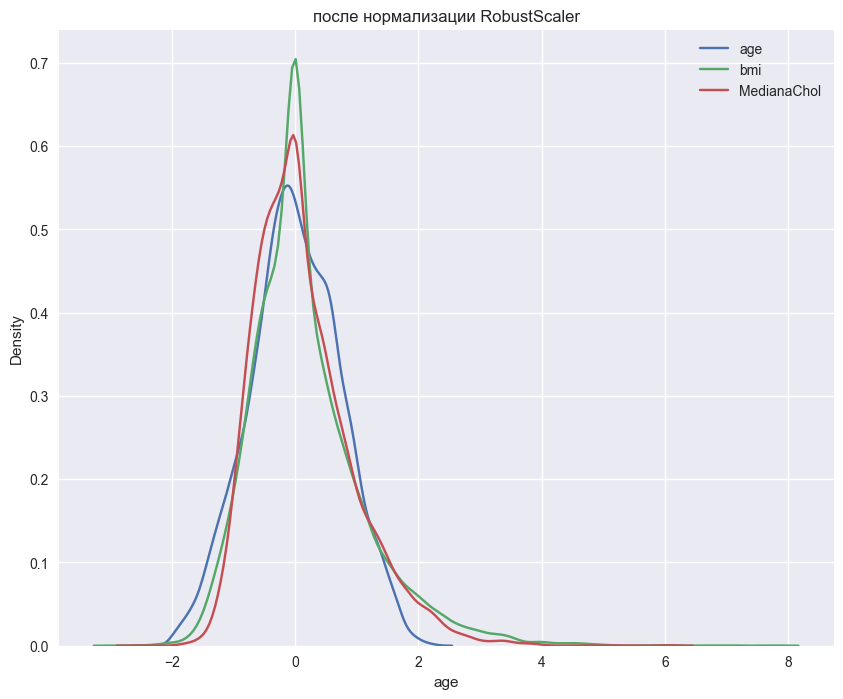

In [85]:
r_scaler = RobustScaler()

df_r = r_scaler.fit_transform(filtered_df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации RobustScaler')


sns.kdeplot(df_r['age'], ax=ax1, label='age')
sns.kdeplot(df_r['bmi'], ax=ax1, label='bmi')
sns.kdeplot(df_r['MedianaChol'], ax=ax1, label='MedianaChol')
plt.legend()

Результат улучшился, применим RobustScaler к данным:

In [86]:
digital_features = ['age', 'bmi', 'MedianaChol']
r_scaler = RobustScaler()
for column in digital_features:
       train_data[column] = r_scaler.fit_transform(train_data[[column]])[:,0]

In [89]:
data = train_data.copy()

# Моделирование

## Логистическая регрессия

In [90]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = data[['diabetes', 'bmi']]
y = data['nafld']

In [91]:
from sklearn import linear_model #линейные модели

In [92]:
#Создаём объект класса LogisticRegression
log_reg_2d = linear_model.LogisticRegression(random_state=42)
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X, y)
#Выводим результирующие коэффициенты
print('w0: {}'.format(log_reg_2d.intercept_)) #свободный член w0
print('w1, w2: {}'.format(log_reg_2d.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: [-1.14768267]
w1, w2: [[0.57457433 0.64062854]]


In [95]:
#Значения наличия диабета и индекса массы тела для пациента
x_new = [[1, 51]]
#Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print('Predicted probabilities: {}'.format(np.round(y_new_proba_predict, 2)))

Predicted probabilities: [[0. 1.]]


c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [96]:
#Значения концентации диабета и индекса массы тела для пациента
x_new = [[1, 40]]
#Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print('Predicted class: {}'.format(y_new_predict))

Predicted class: [1]


c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Предсказанный класс равен 1, значит, модель считает, что данный пациент болеет диабетом.

Теперь построим визуализацию нашей модели.

In [97]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


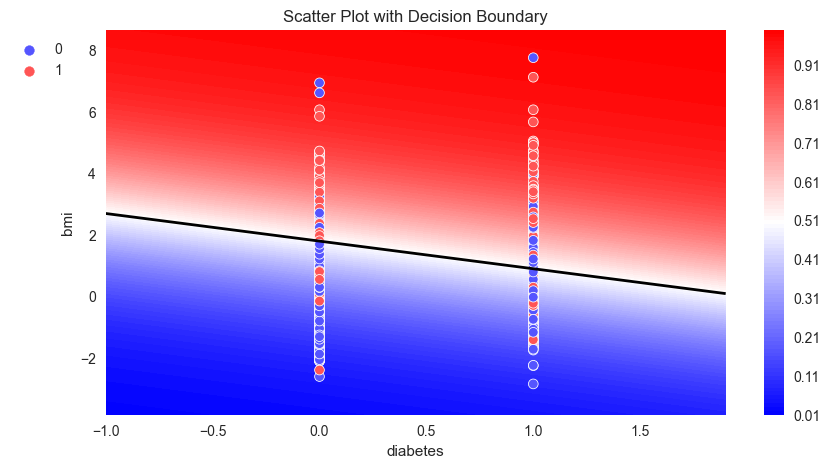

In [98]:
plot_probabilities_2d(X, y, log_reg_2d)

Используем для построения модели всю предоставленную нам информацию — все факторы из набора данных. Для этого заново создадим матрицу наблюдений `X` и вектор ответов `y`:

In [100]:
#Создаем матрицу признаков X и столбец с ответами y
X = data.drop('nafld', axis=1)
y = data['nafld']

In [101]:
#Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg_full.fit(X, y)
#Делаем предсказание класса
y_pred = log_reg_full.predict(X)
#Создадим временную таблицу X
X_temp = X.copy()
#Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,age,bmi,dyslipidemia,ang/isc,diabetes,stroke,afib,htn,MedianaChol,bmi_category_obese (class I),bmi_category_obese (class II),bmi_category_pre-obesity,bmi_category_healthy,bmi_category_underweight,result_chol_mediana_low,result_chol_mediana_nan,result_hdl_mediana_nan,Prediction
12418,0.000000,0.549296,1,0,0,0,0,0,-0.250000,1,0,0,0,0,0,0,0,0
12419,-0.526316,-1.253521,0,0,0,0,0,0,0.638889,0,0,0,1,0,0,0,0,0
12420,-0.210526,2.521127,1,1,1,0,0,1,-0.750000,0,0,0,0,0,1,0,0,1
12421,0.157895,-1.309859,1,0,0,0,0,0,0.250000,0,0,0,1,0,0,0,0,0
12422,0.684211,-0.028169,1,0,1,0,0,0,-0.416667,0,0,1,0,0,0,0,0,0


#### Метрики классификации

In [102]:
from sklearn import metrics #метрики

Cоставим матрицы ошибок для моделей log_reg_2d и log_reg_full.

Для этого сделаем предсказание наличия диабета для всех пациентов с помощью каждой из моделей:

In [103]:
#Делаем предсказание моделью, обученной на двух признаках 
y_pred1 = log_reg_2d.predict(data[['diabetes', 'bmi']])
#Делаем предсказание моделью, обученной на всех признаках 
y_pred2 = log_reg_full.predict(data.drop('nafld', axis=1))

Построим матрицы ошибок для каждой модели, а затем отобразим их в виде тепловых карт:

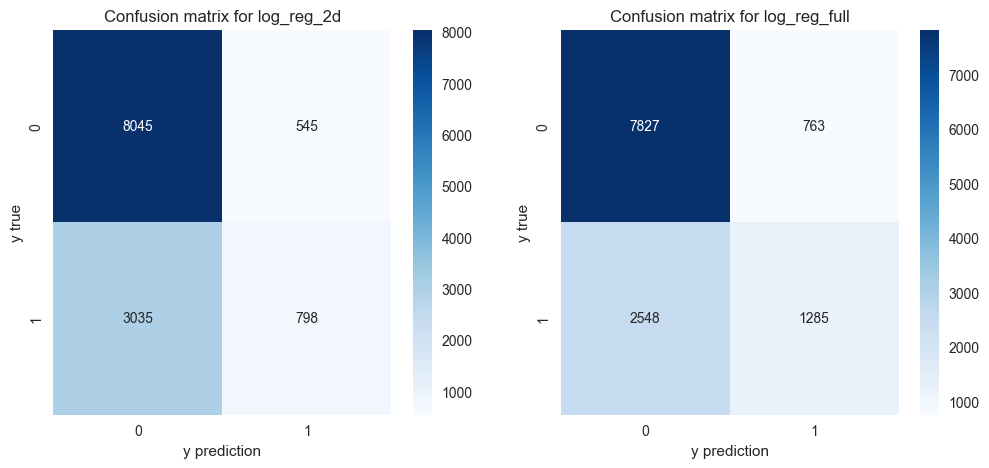

In [104]:
#Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)
#Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #фигура + 2 координатные плоскости
#Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y prediction')
axes[0].set_ylabel('y true')
#Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')
#Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y prediction')
axes[1].set_ylabel('y true');

Расчёт метрик для модели `log_reg_2d`, обученной на двух факторах — Diabet и BMI:

In [105]:
#Модель log_reg_2d:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred1)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred1)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred1)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred1)))

Accuracy: 0.71
Precision: 0.59
Recall: 0.21
F1 score: 0.31


 **Accuracy (Точность)**: Accuracy измеряет общую точность классификации модели. Это отношение числа правильно классифицированных примеров ко всем примерам в наборе данных. В вашем случае, модель достигла точности 0.71, что означает, что 71% примеров были правильно классифицированы.    
**Precision (Точность)**: Precision измеряет, как много из объектов, которые модель классифицировала как положительные, действительно принадлежат к положительному классу. Это отношение True Positives (TP) к сумме TP и False Positives (FP). В вашем случае, модель имеет точность 0.59, что означает, что 59% объектов, классифицированных как положительные, действительно принадлежат к положительному классу.
**Recall (Полнота)**: Recall измеряет, как много объектов из положительного класса модель смогла обнаружить. Это отношение TP к сумме TP и False Negatives (FN). В вашем случае, модель имеет полноту 0.21, что означает, что только 21% объектов положительного класса были обнаружены.
**F1 Score (F1-мера)**: F1-мера - это гармоническое среднее точности и полноты. Она помогает объединить эти две метрики в одну, учитывая как точность, так и полноту. Это особенно полезно, когда у вас есть дисбаланс классов. F1-мера равна 0.31 в вашем случае.

Расчёт метрик для модели `log_reg_full`, обученной на всех доступных факторах:

In [106]:
#Модель log_reg_full:
#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y, y_pred2)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y, y_pred2)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y, y_pred2)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y, y_pred2)))

Accuracy: 0.73
Precision: 0.63
Recall: 0.34
F1 score: 0.44


А теперь давайте сравним:

* Accuracy: доля правильных ответов для первой модели составляет 0.71, для второй — 0.73.
* Precision: способность первой модели отделять больных nafld пациентов от здоровых пациентов составляет 0.59, а второй — 0.63.
* Recall: обобщающая способность находить больных пациентов среди всех пациентов для первой модели — 0.21, а для второй — 0.33.
* $F_1$: среднее гармоническое между precision и recall для первой модели составляет 0.31, а для второй — 0.44.

Для облегчения расчёта метрик можно использовать функцию `classification_report()` из модуля `metrics`. Она возвращает отчёт обо всех метриках классификации:

In [107]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.91      0.83      8590
           1       0.63      0.34      0.44      3833

    accuracy                           0.73     12423
   macro avg       0.69      0.62      0.63     12423
weighted avg       0.72      0.73      0.71     12423



Что здесь отображено?

1. В первой части таблицы отображаются метрики precision, recall и f1-score, рассчитанные для каждого класса в отдельности. Столбец support — это количество объектов каждого из классов.
2. Во второй части таблицы отображена общая метрика accuracy. 
3. Далее идёт строка macro avg — это среднее значение метрики между классами 1 и 0. Например, значение в строке macro avg и столбце recall = (0.91 + 0.33)/2=0.62.
4. Завершает отчёт строка weighted avg — это средневзвешенное значение метрики между классами 1 и 0. Вес каждого класса определяется на основе доли объекта i-ого класса в выборке. 

Представим ситуацию, что дополнительная диагностика диабета в нашей клинике довольно дорогая. Но при этом нам важно выявить диабет у как можно большего числа людей. То есть нам важны и precision, и recall.

При этом наш recall равен 0.34, то есть мы находим только 34 % больных НАЖБП пациентов среди всех болеющих НАЖБП. Согласитесь, не очень хороший показатель (чуть выше половины). Можем ли мы его как-то улучшить?

Давайте будем изменять порог принятия решений. Сейчас порог составляет 0.5: то есть если вероятность наличия диабета у пациента выше 0.5, то модель относит его к больным диабетом, а если меньше 0.5 — к здоровым.

Но как будут меняться значения метрик recall, precision и $F_1$, если мы попробуем изменить порог вероятности, например на 0.4, 0.3 или 0.6? Давайте проследим за этим.



Сделаем предсказание вероятности наличия диабета моделью `log_reg_full` для каждого пациента из нашей выборки. Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [109]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(data.drop('nafld', axis=1))[:, 1]
#Для удобства завернём numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Теперь у нас есть три списка (recall_scores, precision_scores и f1_scores), в которых хранятся значения метрик при различных значениях порога вероятности `p`.

Давайте построим графики зависимости метрик от порога вероятности:

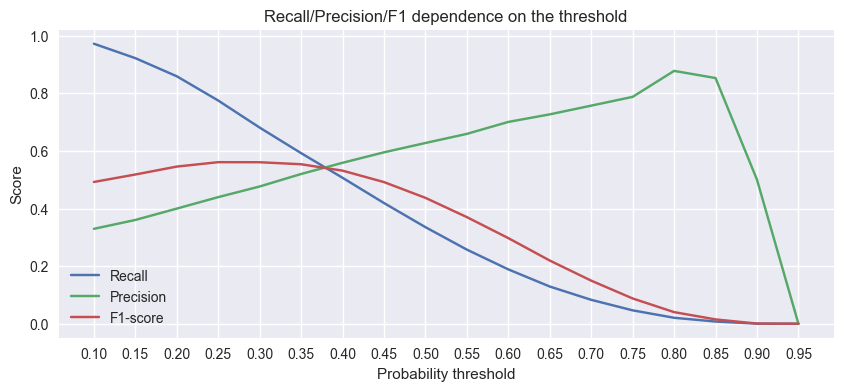

In [110]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

#Даём названия графику и осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Что мы видим на графике?

С увеличением вероятностного порога повышается precision и падает recall. Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение $F_1$-меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка `threshold=0.4`, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства $F_1$-меры.

Однако максимум $F_1$-меры достигается в другой точке — `threshold=0.35`. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что всё-таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при `threshold=0.4`.

Как теперь мы можем сделать предсказание класса, обладая данной информацией?

Мы делаем предсказание вероятности наличия диабета для всех пациентов, а затем вручную определяем всех пациентов, у которых эта вероятность > 0.37, в класс 1, а остальных — в класс 0. Далее считаем метрики:

In [158]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.37
#Пациентов, для которых вероятность наличия НАЖБП > 0.37, относим к классу 1
#В противном случае — к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      8590
           1       0.54      0.56      0.55      3833

    accuracy                           0.71     12423
   macro avg       0.67      0.67      0.67     12423
weighted avg       0.72      0.71      0.72     12423



In [ ]:
Метрики улучшились

## Дерево решений

In [127]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=2,
    max_depth=4, # можно еще max_depth=5
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.42
Test: 0.41


F1-мера равная 0,42 указывает на баланс между точностью и полнотой в вашей модели классификации.
Значение 0,42 говорит о том, что модель достигла относительно умеренной производительности, но есть место для улучшений, особенно если вы хотите улучшить точность и полноту.

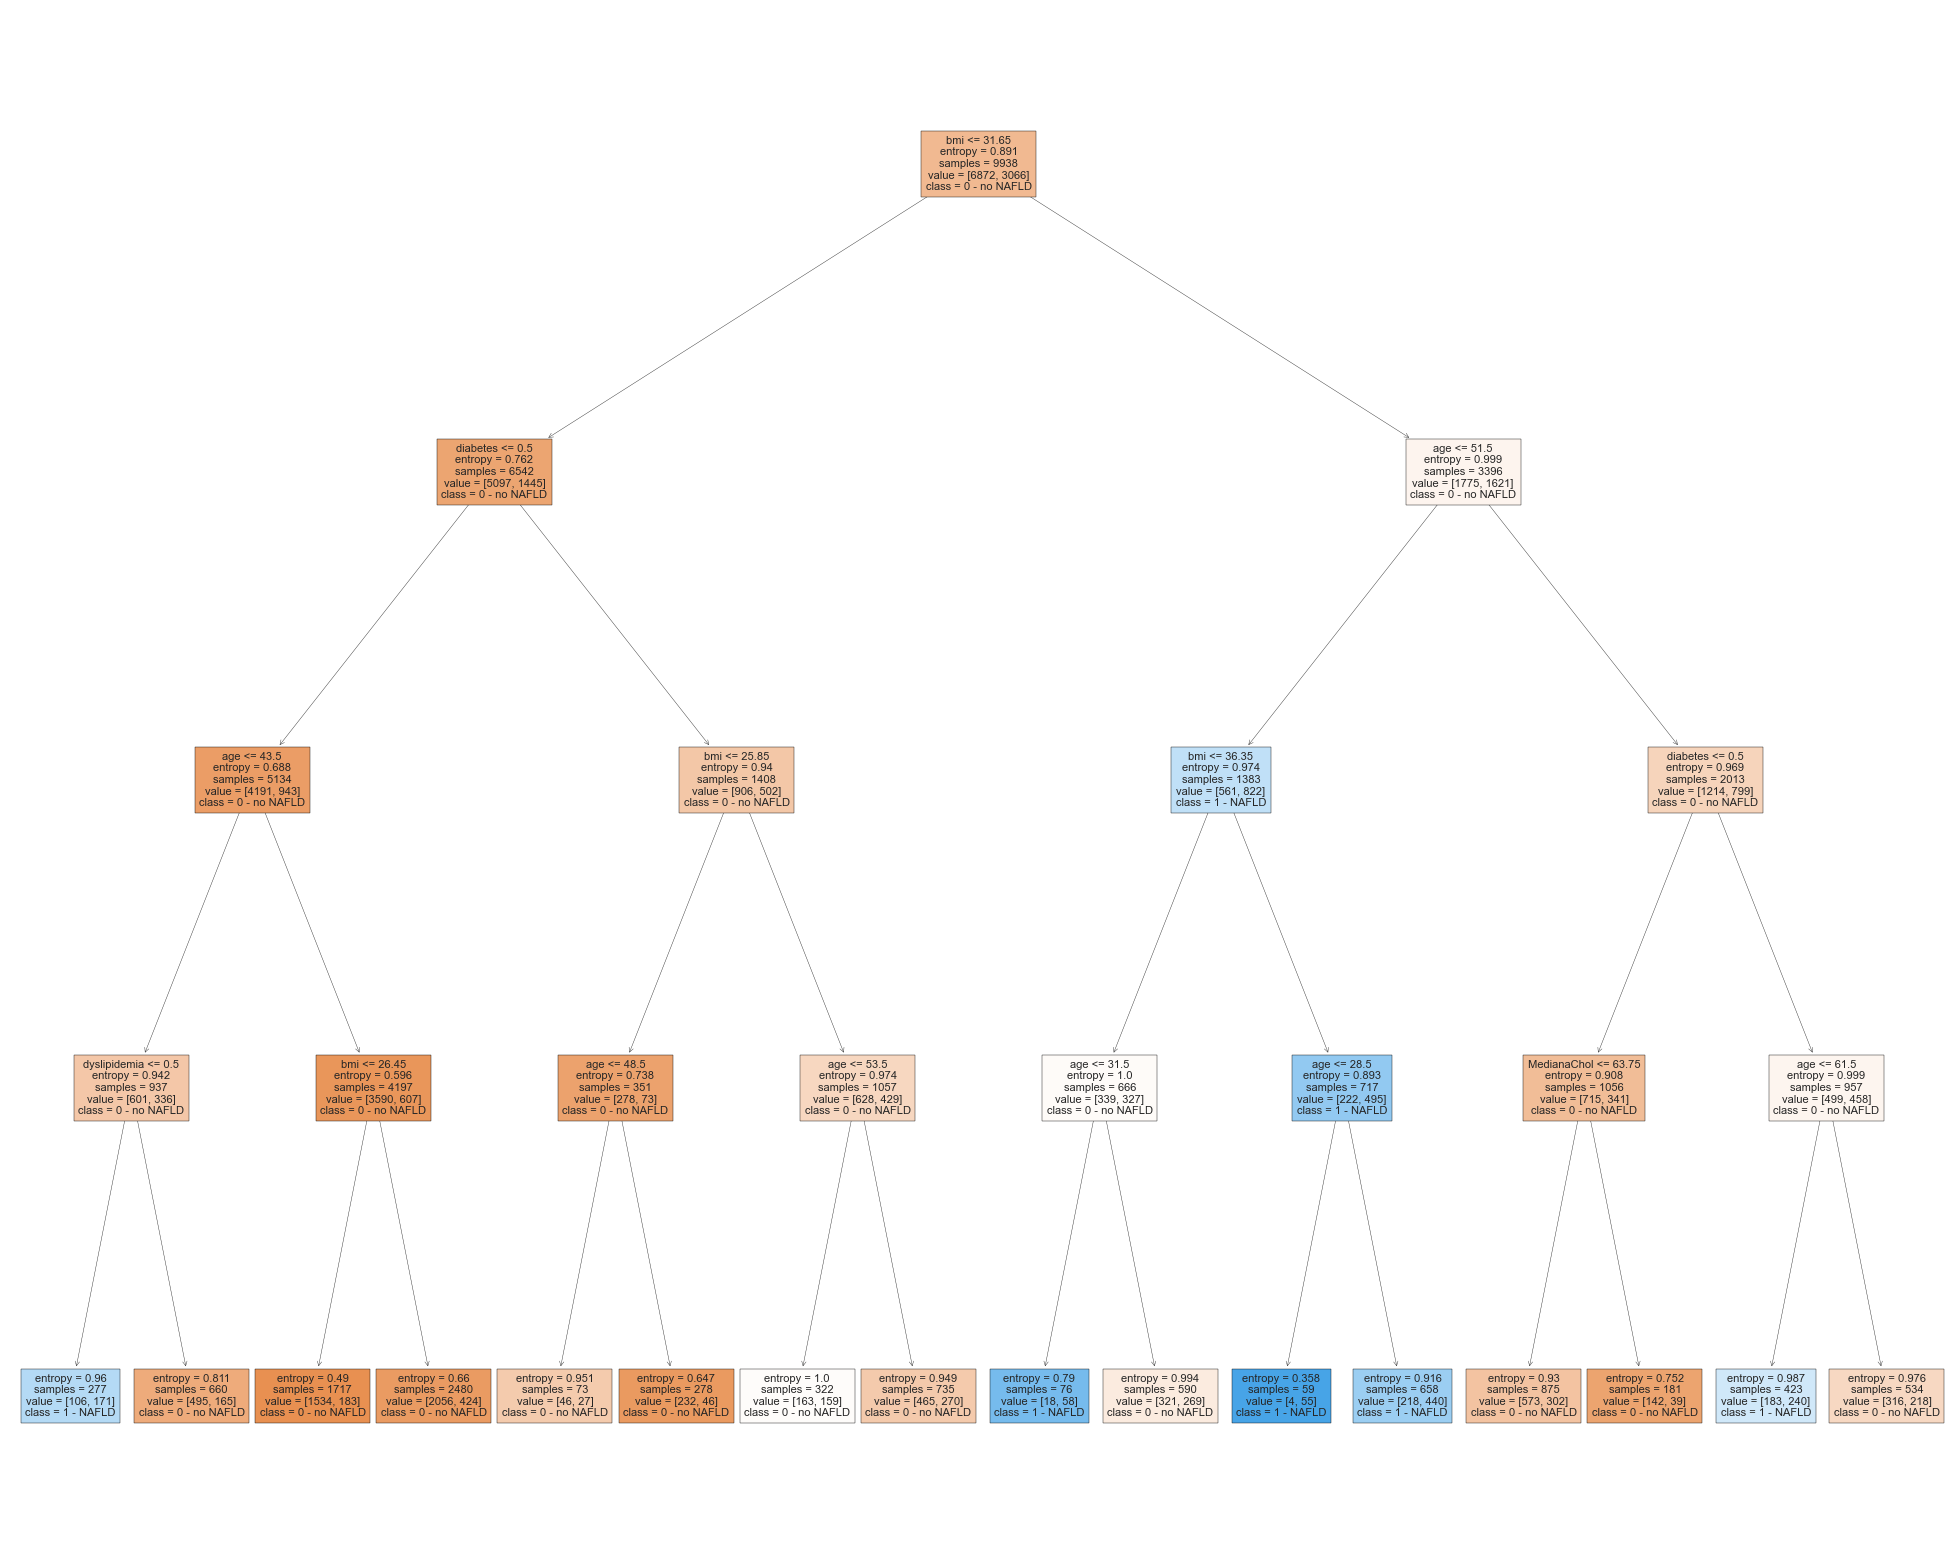

In [128]:
#Создаем фигуру для визуализации графа
fig = plt.figure(figsize=(25,20))
#Строим граф дерева решений
tree_graph = tree.plot_tree(
     dt, #объект обученного дерева
     feature_names=X_train.columns, #наименования факторов
     class_names=["0 - no NAFLD", "1 - NAFLD"], #имена классов
     filled=True, #расцветка графа
 );

#### Бэггинг. Случайный лес

In [134]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    criterion='entropy',
    min_samples_leaf=3,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.55
Test: 0.44


F1-мера в 0,55 для случайного леса указывает на хороший баланс между точностью и полнотой в вашей модели классификации. Значение 0,55 говорит о том, что ваш случайный лес достигает относительно хорошей производительности в совокупности с точностью и полнотой.

Чем ближе F1-мера к 1, тем лучше производительность модели в терминах как точности, так и полноты. Значение 0,55 может считаться довольно неплохим результатом, но все же необходимо повысить точность и полноту.

 F1-мера на тренировочных данных  выше, чем на тестовых данных, что может свидетельствовать о переобучении модели.

c:\Users\Елена\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


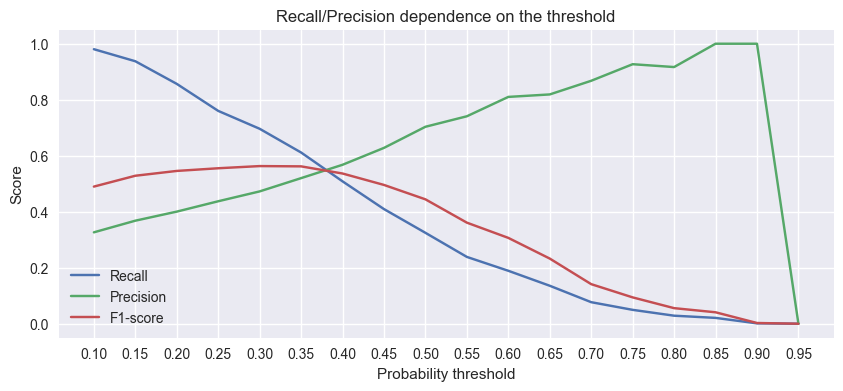

In [160]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [138]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.37
#Людей, у которых вероятность развития НАЖБП относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1718
           1       0.54      0.57      0.55       767

    accuracy                           0.72      2485
   macro avg       0.67      0.68      0.67      2485
weighted avg       0.72      0.72      0.72      2485



Проведем кросс-валидацию, чтобы избежать переобучения модели

In [161]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
test_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_test)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    test_metrics.append(metrics.accuracy_score(y_test, y_valid_pred))
    
    
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(test_metrics)))

Train k-fold mean accuracy: 0.76
Valid k-fold mean accuracy: 0.74


In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    RandomForestClassifier(n_estimators=250)
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=250))])

ROC-кривая

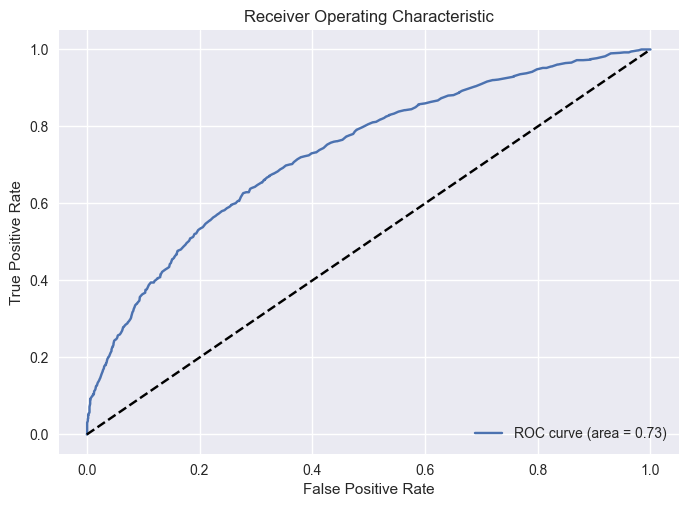

In [165]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
predicted_probabilities = pipeline.predict_proba(X_test)

# Compute the false positive rate, true positive rate, and thresholds

fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities[:, 1])
# Compute the Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Рабочая характеристика приемника (ROC)
  Визуализация кривой:
Этот код генерирует и строит кривую ROC для оценки производительности модели двоичной классификации. Он использует прогнозируемые вероятности для вычисления уровня ложноположительных результатов, истинно положительного результата и пороговых значений. Полученная кривая демонстрирует компромисс между истинно положительными и ложноположительными показателями, при этом показатель AUC представляет общую эффективность.

Mass Training Of Multi-Class-Single-Label Estimators - Массовое обучение оценщиков с несколькими классами и одной меткой

In [166]:
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  
from sklearn.naive_bayes import GaussianNB  
from sklearn.tree import DecisionTreeClassifier  


In [167]:
classifiers = {
    "KNeighborsClassifier3": KNeighborsClassifier(n_neighbors=3),
    "KNeighborsClassifier15": KNeighborsClassifier(n_neighbors=15),
    "KNeighborsClassifier20": KNeighborsClassifier(n_neighbors=20),
    "SVC": make_pipeline(StandardScaler(), SVC(gamma='auto')),
    "LinearDiscriminantAnalysis":LinearDiscriminantAnalysis(),
    "GaussianNB":GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}

In [64]:
#Создаем матрицу признаков X и столбец с ответами y
# X = train_data.drop('nafld', axis=1)
# y = train_data['nafld']

# X_train, X_test, y_train, y_test= model_selection.train_test_split(X, y, stratify=y,
# test_size=0.2, random_state=1)

In [168]:
scorenames={}

for name, clf in zip(list(classifiers.keys()), list(classifiers.values())):
    skip = False
    scores = []
    for i in range(10):
        try:
            clf.fit(X_train, y_train)
            scores.append(clf.score(X_test, y_test))
        except:
            skip=True
    if skip == True: continue
    score = 0
    for onescore in scores:
        score += onescore
    score = score / 10
    scorenames[name] = score

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


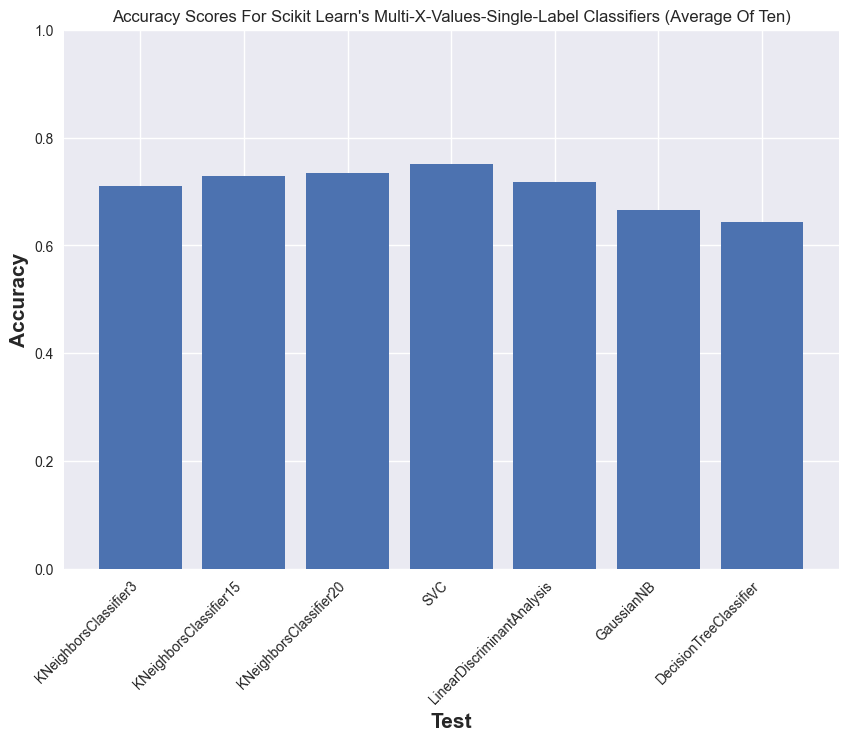

In [169]:
 
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(scorenames.keys(), scorenames.values())
plt.xticks(rotation=45, ha='right')
 
plt.xlabel('Test', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.title("Accuracy Scores For Scikit Learn's Multi-X-Values-Single-Label Classifiers (Average Of Ten)")
plt.ylim(top = 1)
plt.legend()
plt.show()


In [170]:
scorenames = dict([(value, key) for key, value in scorenames.items()])
print("Maximum Score:", max(list(scorenames.keys())), "with", scorenames[max(list(scorenames.keys()))])

Maximum Score: 0.7512077294685992 with SVC


Using GridSearchCV To Tune SVC


In [171]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

grid_predictions = grid.predict(X_test)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
  
# print classification report
print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=1000, gamma=0.01)

 The best score across ALL searched params:
 0.7560117625734275

 The best parameters across ALL searched params:
 {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1691
           1       0.70      0.35      0.47       793

    accuracy                           0.75      2484
   macro avg       0.73      0.64      0.65      2484
weighted avg       0.74      0.75      0.72      2484



In [178]:

best_params = {'C': [1000], 
              'gamma': [0.01],
              'kernel': ['rbf']} 
svc = SVC()
grid_search = GridSearchCV(svc, best_params, cv=5)  # You can specify the number of cross-validation folds

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model = grid_search.best_estimator_

# Make predictions
cb_y_train_pred = best_model.predict(X_train)
cb_y_test_pred = best_model.predict(X_test)

In [186]:
#создадим функцию принимающую выборки, предсказания и название модели, а возвращающую словарь со значениями метрик
def metrics_func(y_train,y_test,y_train_pred,y_test_pred, model_name):
    metric_dic = {'Metric': ['Train recall', 'Test recall', 'Train precision', 'Test precision', 'Train F1', 'Test F1']}
    recall_train = metrics.recall_score(y_train, y_train_pred)
    recall_test = metrics.recall_score(y_test, y_test_pred)
    precision_train = metrics.precision_score(y_train, y_train_pred)
    precision_test = metrics.precision_score(y_test, y_test_pred)
    f1_train = metrics.f1_score(y_train, y_train_pred)
    f1_test = metrics.f1_score(y_test, y_test_pred)
    
    
      
    metric_dic[model_name] = [round(recall_train,2), round(recall_test,2), round(precision_train,2), round(precision_test,2), round(f1_train,2), round(f1_test,2)]
           
    return metric_dic

In [187]:
cb_dic = metrics_func(y_train, y_test, cb_y_train_pred, cb_y_test_pred, 'SVC(Optimal)')
display(pd.DataFrame(cb_dic))
print(best_params)

,Metric,SVC(Optimal)
0,Train recall,0.33
1,Test recall,0.35
2,Train precision,0.75
3,Test precision,0.70
4,Train F1,0.46
5,Test F1,0.47


{'C': [1000], 'gamma': [0.01], 'kernel': ['rbf']}


# Продакт
Сохраненим нашу обученную модел в файл *pickle*.  Затем создадим *requirements.txt*, напишем *flask* сервер (server.py) и клиент(client.py). Создадим *docker*-контейнер на основе *tiangolo/uwsgi-nginx-flask*.

In [188]:
import pickle

In [189]:
with open("web/app/model/best_cb_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [ ]:
#pip freeze > requirements.txt